In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

import utils
import compress

/home/t.desilva/.conda/envs/myEnv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device name:', torch.cuda.get_device_name(), '\n')

Device name: NVIDIA A100-SXM4-80GB 



In [3]:
traj, n_atoms = utils.read_traj(xtc_='../../Storage/Data/00.xtc', top_='../../Storage/Data/system.pdb')

In [6]:
batch_size = 128

traj_dl = DataLoader(traj, batch_size=batch_size, shuffle=True, drop_last=True)
# norm_traj_dl = DataLoader(utils.minMaxScale(traj), batch_size=batch_size, shuffle=True, drop_last=True) # modified to be in range(0,1)

In [16]:
model = compress.AE(n_atoms=n_atoms).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

summary(model, input_size=(batch_size, 1, n_atoms, 3))

Layer (type:depth-idx)                   Output Shape              Param #
AE                                       [128, 1, 127, 3]          --
├─Sequential: 1-1                        [128, 20]                 --
│    └─Conv2d: 2-1                       [128, 4096, 1, 3]         524,288
│    └─LeakyReLU: 2-2                    [128, 4096, 1, 3]         --
│    └─BatchNorm2d: 2-3                  [128, 4096, 1, 3]         8,192
│    └─Conv2d: 2-4                       [128, 1024, 1, 1]         12,583,936
│    └─LeakyReLU: 2-5                    [128, 1024, 1, 1]         --
│    └─BatchNorm2d: 2-6                  [128, 1024, 1, 1]         2,048
│    └─Flatten: 2-7                      [128, 1024]               --
│    └─Linear: 2-8                       [128, 512]                524,800
│    └─BatchNorm1d: 2-9                  [128, 512]                1,024
│    └─LeakyReLU: 2-10                   [128, 512]                --
│    └─Linear: 2-11                      [128, 256]       

In [8]:
def training_batch(data, model, optimizer):
    model.train()
    data = data.to(device)
    recon = model(data)
    loss = loss_function(recon, data)
    avg_RMSD = RMSD_(recon, data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, avg_RMSD

In [9]:
def RMSD_(recon, x, reduce='mean'):
    avg_RMSD = 0.0
    x1 = recon.to(device).reshape(-1,recon.shape[2], 3)
    x2 = x.to(device).reshape(-1,recon.shape[2], 3)
    for i in range(len(x1)):
        avg_RMSD += torch.sqrt(torch.mean(torch.sum((x1[i] - x2[i])**2, axis=0)))
    if reduce == 'mean':
        return avg_RMSD/len(x1)
    if reduce == 'sum':
        return avg_RMSD

In [11]:
def loss_function(recon, x):
    criterion = compress.RMSDLoss()
    rmsd = criterion(recon, x)
    return rmsd

In [12]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

n_epochs = 100

training_loss = []
RMSD = []

for epoch in range(n_epochs):
    training_losses = []
    RMSDs = []
    
    for data in traj_dl:
        data = data.reshape(-1,1,model.n_atoms,3).to(device)
        # org = org.reshape(-1,1,127,3).to(device)
        trng_batch_loss, avg_RMSD = training_batch(data, model, optimizer)
        training_losses.append(trng_batch_loss.item())
        RMSDs.append(avg_RMSD.item())
    training_per_epoch_loss = np.array(training_losses).mean()
    rmsd_per_epoch = np.array(RMSDs).mean()
    
    training_loss.append(training_per_epoch_loss)
    RMSD.append(rmsd_per_epoch)
    
    if (epoch+1) % 10==0:
        print(f'Epoch: {epoch+1:>3d}/{n_epochs}\t|\t Mean training loss: {training_per_epoch_loss:7.4f} \t|\t mean_RMSD = {rmsd_per_epoch:5.3f}  \n')

Epoch:  10/100	|	 Mean training loss:  0.1216 	|	 mean_RMSD = 1.292  

Epoch:  20/100	|	 Mean training loss:  0.1009 	|	 mean_RMSD = 1.063  

Epoch:  30/100	|	 Mean training loss:  0.0872 	|	 mean_RMSD = 0.917  

Epoch:  40/100	|	 Mean training loss:  0.0790 	|	 mean_RMSD = 0.835  

Epoch:  50/100	|	 Mean training loss:  0.0763 	|	 mean_RMSD = 0.805  

Epoch:  60/100	|	 Mean training loss:  0.0717 	|	 mean_RMSD = 0.756  

Epoch:  70/100	|	 Mean training loss:  0.0686 	|	 mean_RMSD = 0.731  

Epoch:  80/100	|	 Mean training loss:  0.0669 	|	 mean_RMSD = 0.700  

Epoch:  90/100	|	 Mean training loss:  0.0645 	|	 mean_RMSD = 0.681  

Epoch: 100/100	|	 Mean training loss:  0.0626 	|	 mean_RMSD = 0.657  



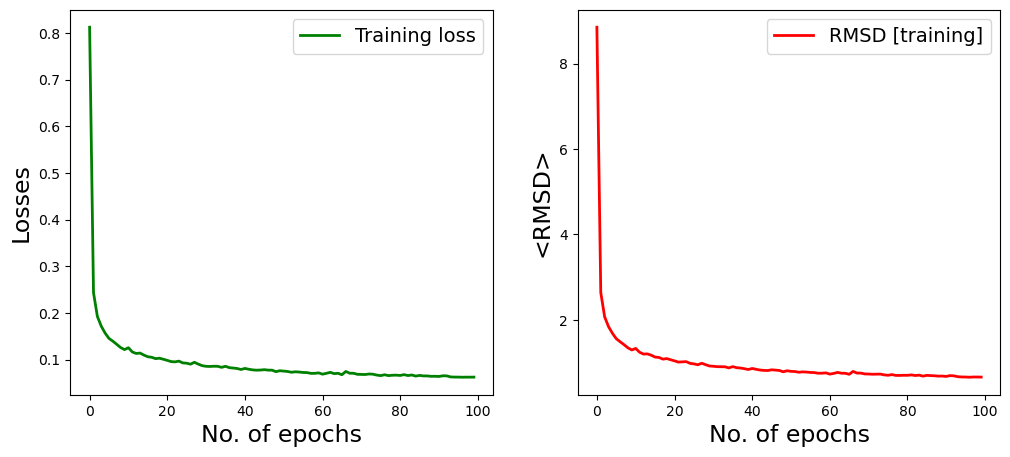

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

ax[0].plot(training_loss, 'g-', linewidth=2, label='Training loss')
ax[1].plot(RMSD, 'r-', linewidth=2, label='RMSD [training]')
# plt.plot(test_loss, 'c--', linewidth=2, label='Test loss')

ax[0].set_xlabel('No. of epochs', fontsize=17)
ax[0].set_ylabel('Losses', fontsize=17)
ax[0].legend(fontsize=14)
ax[1].set_xlabel('No. of epochs', fontsize=17)
ax[1].set_ylabel('<RMSD>', fontsize=17)
# ax[1].set_ylim(0,0.2)
ax[1].legend(fontsize=14);

In [14]:
model.eval()
x1 = model(torch.tensor(traj[:2]).reshape(2,1,127,3).to(device))
x2 = torch.tensor(traj[0]).to(device)

loss_function(x1,x2).item()

0.06376423686742783

In [15]:
torch.sqrt(torch.mean((x1-x2)**2)).item()/2

0.03188211843371391